# The Nature Conservancy Fisheries Monitoring - SCUS 
<pre>
mode:  scus - alb, layer3, closest samples
arch:  resnet50
seed:  0
</pre>

In [1]:
import platform
import random
import torch
import torchvision
import fastai
from fastai.vision.all import *
import albumentations
from albumentations import (
    Compose,GaussianBlur,HorizontalFlip,MedianBlur,MotionBlur,OneOf,
    RandomBrightness,RandomContrast,Resize,ShiftScaleRotate,VerticalFlip
)
import cv2
import sklearn
from sklearn.metrics import roc_auc_score
import pandas as pd
import numpy as np

print('python version:       {}'.format(platform.python_version()))
print('torch version:        {}'.format(torch.__version__))
print('torchvision version:  {}'.format(torchvision.__version__))
print('fastai version:       {}'.format(fastai.__version__))
print('albumination version: {}'.format(albumentations.__version__))
print('opencv version:       {}'.format(cv2.__version__))
print('sklearn version:      {}'.format(sklearn.__version__))
print('pandas version:       {}'.format(pd.__version__))
print('numpy version:        {}'.format(np.__version__))

use_cuda = torch.cuda.is_available()
print('CUDA available:       {}'.format(use_cuda))
print('cuDNN enabled:        {}'.format(torch.backends.cudnn.enabled))
print('num gpus:             {}'.format(torch.cuda.device_count()))

if use_cuda:
    print('gpu:                  {}'.format(torch.cuda.get_device_name(0)))

    print()
    print('------------------------- CUDA -------------------------')
    ! nvcc --version

python version:       3.7.10
torch version:        1.7.0
torchvision version:  0.8.1
fastai version:       2.3.0
albumination version: 0.5.2
opencv version:       4.5.1
sklearn version:      0.24.1
pandas version:       1.1.5
numpy version:        1.19.5
CUDA available:       True
cuDNN enabled:        True
num gpus:             1
gpu:                  Tesla P100-PCIE-16GB

------------------------- CUDA -------------------------
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Wed_Jul_22_19:09:09_PDT_2020
Cuda compilation tools, release 11.0, V11.0.221
Build cuda_11.0_bu.TC445_37.28845127_0


In [2]:
seed = 0

data_dir = Path('./train')

## Load Data from Kaggle

In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/the-nature-conservancy-fisheries-monitoring/train.zip
/kaggle/input/the-nature-conservancy-fisheries-monitoring/test_stg2.7z
/kaggle/input/the-nature-conservancy-fisheries-monitoring/test_stg1.zip
/kaggle/input/the-nature-conservancy-fisheries-monitoring/sample_submission_stg2.csv.zip
/kaggle/input/the-nature-conservancy-fisheries-monitoring/sample_submission_stg1.csv.zip
/kaggle/input/fmacusds/fm_train_df_undersamp_alb_layer3_closest_resnet50_s0.csv
/kaggle/input/fmacusds/fm_train_df_undersamp_alb_layer2_farthest_resnet50_s0.csv
/kaggle/input/fmacusds/fm_train_df_undersamp_alb_layer1_farthest_resnet50_s0.csv
/kaggle/input/fmacusds/fm_train_df_undersamp_alb_layer1_closest_more_resnet50_s0.csv
/kaggle/input/fmacusds/fm_train_df_undersamp_alb_layer2_closest_resnet50_s0.csv
/kaggle/input/fmacusds/fm_train_df_undersamp_alb_layer1_closest_resnet50_s0.csv
/kaggle/input/fmacusds/fm_train_df_undersamp_alb_layer3_farthest_resnet50_s0.csv
/kaggle/input/fmacusds/fm_train_df_undersam

In [4]:
!cp /kaggle/input/the-nature-conservancy-fisheries-monitoring/train.zip .
!unzip train.zip
!rm train/.DS_Store

Archive:  train.zip
   creating: train/
  inflating: train/.DS_Store         
   creating: __MACOSX/
   creating: __MACOSX/train/
  inflating: __MACOSX/train/._.DS_Store  
   creating: train/ALB/
  inflating: train/ALB/img_00003.jpg  
  inflating: train/ALB/img_00010.jpg  
  inflating: train/ALB/img_00012.jpg  
  inflating: train/ALB/img_00015.jpg  
  inflating: train/ALB/img_00019.jpg  
  inflating: train/ALB/img_00020.jpg  
  inflating: train/ALB/img_00029.jpg  
  inflating: train/ALB/img_00032.jpg  
  inflating: train/ALB/img_00037.jpg  
  inflating: train/ALB/img_00038.jpg  
  inflating: train/ALB/img_00039.jpg  
  inflating: train/ALB/img_00041.jpg  
  inflating: train/ALB/img_00043.jpg  
  inflating: train/ALB/img_00045.jpg  
  inflating: train/ALB/img_00055.jpg  
  inflating: train/ALB/img_00057.jpg  
  inflating: train/ALB/img_00074.jpg  
  inflating: train/ALB/img_00085.jpg  
  inflating: train/ALB/img_00090.jpg  
  inflating: train/ALB/img_00097.jpg  
  inflating: train/ALB/i

In [5]:
# Create DataFrame from Dataset
df_data = []
labels = []
for c in data_dir.iterdir():
    labels.append(c.name)
    for f in c.iterdir():
        df_entry = [c.name + '/' + f.name, c.name]
        df_data.append(df_entry)
        
train_df = pd.DataFrame(df_data, columns=['image','label'])
print('Labels: {}'.format(labels)); print(); train_df

Labels: ['OTHER', 'SHARK', 'YFT', 'NoF', 'ALB', 'LAG', 'DOL', 'BET']



,image,label
0,OTHER/img_06700.jpg,OTHER
1,OTHER/img_03246.jpg,OTHER
2,OTHER/img_00332.jpg,OTHER
3,OTHER/img_01697.jpg,OTHER
4,OTHER/img_02099.jpg,OTHER
...,...,...
3772,BET/img_02007.jpg,BET
3773,BET/img_00231.jpg,BET
3774,BET/img_05728.jpg,BET
3775,BET/img_05351.jpg,BET


## Undersampling

In [6]:
alb_train_df = pd.read_csv('../input/fmacusds/fm_train_df_undersamp_alb_layer3_closest_resnet50_s0.csv')

train_df = pd.concat(
    [train_df.query('label == "YFT"')] +
    [train_df.query('label == "NoF"')] +
    [train_df.query('label == "OTHER"')] +
    [train_df.query('label == "BET"')] +
    [train_df.query('label == "SHARK"')] +
    [train_df.query('label == "DOL"')] +
    [train_df.query('label == "LAG"')] +
    [alb_train_df]
).sample(frac=1.0, random_state=seed).reset_index(drop=True)

print('Samples: {}'.format(train_df.shape[0]))
train_df.head()

Samples: 2795


,image,label
0,SHARK/img_02169.jpg,SHARK
1,NoF/img_00529.jpg,NoF
2,NoF/img_01475.jpg,NoF
3,NoF/img_07274.jpg,NoF
4,BET/img_02742.jpg,BET


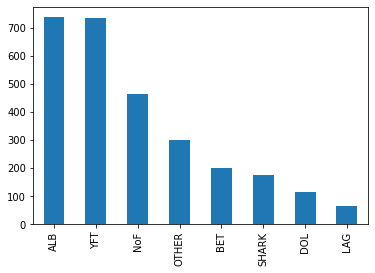

In [7]:
# Plot Sample Counts per Class
train_df['label'].value_counts().plot(kind='bar');

In [8]:
df = pd.DataFrame({
    'train': train_df['label'].value_counts()
})

df["train_pct"] = df["train"]/df["train"].sum(); df

,train,train_pct
ALB,737,0.263685
YFT,734,0.262612
NoF,465,0.166369
OTHER,299,0.106977
BET,200,0.071556
SHARK,176,0.062970
DOL,117,0.041860
LAG,67,0.023971


In [9]:
# Save Data Df
train_df.to_csv('fm_train_df_acus_layer3_c_resnet50_s0.csv', index=False)

## Load Data into Fastai DataLoader

In [10]:
# Define Data Augmentation Functions
# similar to: https://isaac-flath.github.io/fastblog/computer%20vision/image%20classification/kaggle/2021/02/15/PlantPathologyKaggle.html
# but without vertical flip (since the image is not from above)

class AlbumentationsTransform(RandTransform):
    "A transform handler for multiple `Albumentation` transforms"
    split_idx,order = None,2
    def __init__(self, train_aug, valid_aug): store_attr()
    
    def before_call(self, b, split_idx):
        self.idx = split_idx
    
    def encodes(self, img: PILImage):
        if self.idx == 0:
            aug_img = self.train_aug(image=np.array(img))['image']
        else:
            aug_img = self.valid_aug(image=np.array(img))['image']

        return PILImage.create(aug_img)
    
    
def get_train_aug(image_size): 
    return Compose([
        Resize(height=image_size[0], width=image_size[1]),
        OneOf([RandomBrightness(limit=0.1, p=1), RandomContrast(limit=0.1, p=1)]),
        OneOf([MotionBlur(blur_limit=3), MedianBlur(blur_limit=3), GaussianBlur(blur_limit=3)], p=0.5),
        HorizontalFlip(p=0.5),
        ShiftScaleRotate(
            shift_limit=0.2,
            scale_limit=0.2,
            rotate_limit=20,
            interpolation=cv2.INTER_LINEAR,
            border_mode=cv2.BORDER_REFLECT_101,
            p=1,
        ),
    ])


def get_valid_aug(image_size): 
    return  Compose([
        Resize(height=image_size[0], width=image_size[1]),
    ])

In [11]:
# Load Data into Fastai DataLoader and Add Data Augmentation Functions
set_seed(seed, reproducible=True)

image_size = [224,244]
item_tfms  = [AlbumentationsTransform(get_train_aug(image_size), get_valid_aug(image_size))]
batch_tfms = [Normalize.from_stats(*imagenet_stats)]

db = DataBlock(
    blocks=(ImageBlock, CategoryBlock()), 
    getters=[ColReader('image', pref=data_dir), ColReader('label')], 
    splitter=RandomSplitter(valid_pct=0.2, seed=seed),
    item_tfms=item_tfms,
    batch_tfms=batch_tfms
)

dls = db.dataloaders(source=train_df, bs=25, seed=seed)

print('Classes: {}'.format(dls.vocab)); print()
print('Train Samples: {}'.format(len(dls.train_ds)))
print('Valid Samples: {}'.format(len(dls.valid_ds)))
print('Total Samples: {}'.format(len(dls.train_ds) + len(dls.valid_ds)))

/opt/conda/lib/python3.7/site-packages/albumentations/augmentations/transforms.py:2611: UserWarning: blur_limit and sigma_limit minimum value can not be both equal to 0. blur_limit minimum value changed to 3.
  "blur_limit and sigma_limit minimum value can not be both equal to 0. "


Classes: ['ALB', 'BET', 'DOL', 'LAG', 'NoF', 'OTHER', 'SHARK', 'YFT']

Train Samples: 2236
Valid Samples: 559
Total Samples: 2795


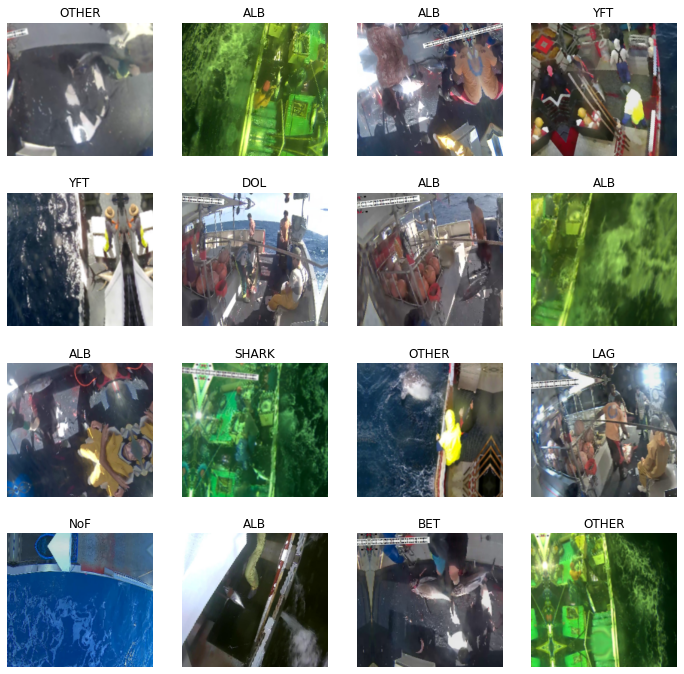

In [12]:
# Show a few Samples
dls.show_batch(max_n=16)

## Model Training

In [13]:
# Define Metric
# actual metric is loss, see: https://www.kaggle.com/c/the-nature-conservancy-fisheries-monitoring/overview/evaluation
# but we also use ROC AUC here

def comp_mean_roc_auc(preds, targs, labels=range(len(labels))):
    targs = np.eye(8)[targs]
    return np.mean([roc_auc_score(targs[:,i], preds[:,i]) for i in labels])

def ALB_roc_auc(*args):
    return comp_mean_roc_auc(*args, labels=[0])

def BET_roc_auc(*args):
    return comp_mean_roc_auc(*args, labels=[1])

def DOL_roc_auc(*args):
    return comp_mean_roc_auc(*args, labels=[2])

def LAG_roc_auc(*args):
    return comp_mean_roc_auc(*args, labels=[3])

def NoF_roc_auc(*args):
    return comp_mean_roc_auc(*args, labels=[4])

def OTHER_roc_auc(*args):
    return comp_mean_roc_auc(*args, labels=[5])

def SHARK_roc_auc(*args):
    return comp_mean_roc_auc(*args, labels=[6])

def YFT_roc_auc(*args):
    return comp_mean_roc_auc(*args, labels=[7])

# Add Competition Matric and Some Other Metrics
metrics = [
    AccumMetric(comp_mean_roc_auc, flatten=False),
    AccumMetric(ALB_roc_auc, flatten=False),
    AccumMetric(BET_roc_auc, flatten=False),
    AccumMetric(DOL_roc_auc, flatten=False),
    AccumMetric(LAG_roc_auc, flatten=False),
    AccumMetric(NoF_roc_auc, flatten=False),
    AccumMetric(OTHER_roc_auc, flatten=False),
    AccumMetric(SHARK_roc_auc, flatten=False),
    AccumMetric(YFT_roc_auc, flatten=False),
    accuracy,
]

In [14]:
# Create Learner
set_seed(seed, reproducible=True)

learn = cnn_learner(
    dls, resnet50, metrics = metrics
).to_fp16()

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

SuggestedLRs(lr_min=0.002754228748381138, lr_steep=0.0008317637839354575)

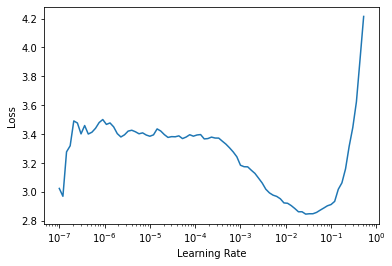

In [15]:
# Find Learning Rate
set_seed(seed, reproducible=True)

learn.lr_find()

In [16]:
# Model Training
set_seed(seed, reproducible=True)

learn.fine_tune(8, base_lr=1e-2, freeze_epochs=3)

epoch,train_loss,valid_loss,comp_mean_roc_auc,ALB_roc_auc,BET_roc_auc,DOL_roc_auc,LAG_roc_auc,NoF_roc_auc,OTHER_roc_auc,SHARK_roc_auc,YFT_roc_auc,accuracy,time
0,1.929585,1.097706,0.914456,0.866475,0.872250,0.965618,0.969118,0.942561,0.839588,0.960883,0.899153,0.633274,00:57
1,1.432882,1.201033,0.894249,0.867916,0.843915,0.991386,0.970833,0.942195,0.825696,0.820286,0.891767,0.649374,00:58
2,1.339146,0.806969,0.939138,0.911419,0.853940,0.971423,0.986887,0.962548,0.946195,0.968054,0.912633,0.744186,00:57


epoch,train_loss,valid_loss,comp_mean_roc_auc,ALB_roc_auc,BET_roc_auc,DOL_roc_auc,LAG_roc_auc,NoF_roc_auc,OTHER_roc_auc,SHARK_roc_auc,YFT_roc_auc,accuracy,time
0,0.883514,0.503898,0.966208,0.930618,0.947925,1.000000,0.990441,0.984107,0.920107,0.992027,0.964436,0.835420,01:57
1,0.892720,1.131491,0.930742,0.904464,0.925404,0.982097,0.766360,0.972464,0.968826,0.983173,0.943149,0.683363,01:57
2,0.787400,0.855892,0.951334,0.973080,0.922689,0.994981,0.959804,0.954469,0.969682,0.987833,0.848137,0.760286,01:57
3,0.593342,0.543041,0.968967,0.984874,0.969229,0.997378,0.935294,0.980699,0.950984,0.980222,0.953058,0.842576,01:57
4,0.415451,0.349771,0.980611,0.946269,0.978766,0.999700,0.990809,0.986033,0.982389,0.978617,0.982307,0.901610,01:57
5,0.245111,0.179140,0.988692,0.991654,0.995823,0.999925,0.980760,0.983620,0.981796,0.988920,0.987039,0.958855,01:57
6,0.170128,0.177469,0.989838,0.989855,0.997285,1.000000,0.982414,0.986498,0.983310,0.984467,0.994871,0.953488,01:57
7,0.101199,0.169140,0.990143,0.989805,0.997320,1.000000,0.985049,0.986144,0.982915,0.984778,0.995131,0.958855,01:57


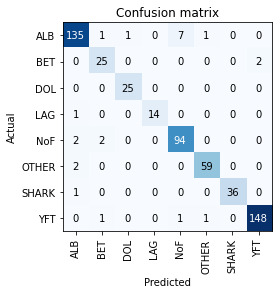

In [17]:
# Plot Confusion Matrix
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

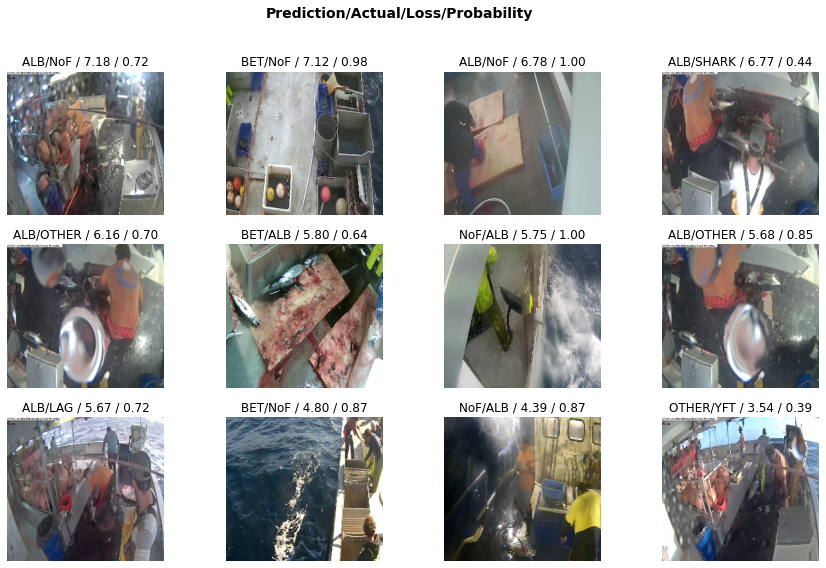

In [18]:
# Plot Top Losses
interp.plot_top_losses(12, figsize=(15,9), nrows=3)

In [19]:
# Print Most Confused Classes
interp.most_confused()

[('ALB', 'NoF', 7),
 ('BET', 'YFT', 2),
 ('NoF', 'ALB', 2),
 ('NoF', 'BET', 2),
 ('OTHER', 'ALB', 2),
 ('ALB', 'BET', 1),
 ('ALB', 'DOL', 1),
 ('ALB', 'OTHER', 1),
 ('LAG', 'ALB', 1),
 ('SHARK', 'ALB', 1),
 ('YFT', 'BET', 1),
 ('YFT', 'NoF', 1),
 ('YFT', 'OTHER', 1)]

In [20]:
# Save Model
learn.save('fm_train_df_acus_layer3_c_resnet50_s0_fastai')
torch.save(learn.model, 'fm_train_df_acus_layer3_c_resnet50_s0.pth')

## Test Set Predictions

In [21]:
!apt-get install p7zip
!apt-get install p7zip-full

Reading package lists... Done
Building dependency tree       
Reading state information... Done
Suggested packages:
  p7zip-full
The following NEW packages will be installed:
  p7zip
0 upgraded, 1 newly installed, 0 to remove and 19 not upgraded.
Need to get 358 kB of archives.
After this operation, 996 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 p7zip amd64 16.02+dfsg-6 [358 kB]
Fetched 358 kB in 0s (1794 kB/s)
debconf: delaying package configuration, since apt-utils is not installed
Selecting previously unselected package p7zip.
(Reading database ... 100757 files and directories currently installed.)
Preparing to unpack .../p7zip_16.02+dfsg-6_amd64.deb ...
Unpacking p7zip (16.02+dfsg-6) ...
Setting up p7zip (16.02+dfsg-6) ...
Reading package lists... Done
Building dependency tree       
Reading state information... Done
Suggested packages:
  p7zip-rar
The following NEW packages will be installed:
  p7zip-full
0 upgraded, 1 ne

In [22]:
!cp /kaggle/input/the-nature-conservancy-fisheries-monitoring/test_stg1.zip .
!cp /kaggle/input/the-nature-conservancy-fisheries-monitoring/test_stg2.7z .
!unzip test_stg1.zip
!mv test_stg1/* train
!mkdir train/test_stg2
!7z e test_stg2.7z -otrain/test_stg2
!rm -rf test_stg1

Archive:  test_stg1.zip
   creating: test_stg1/
  inflating: test_stg1/img_00005.jpg  
  inflating: test_stg1/img_00007.jpg  
  inflating: test_stg1/img_00009.jpg  
  inflating: test_stg1/img_00018.jpg  
  inflating: test_stg1/img_00027.jpg  
  inflating: test_stg1/img_00030.jpg  
  inflating: test_stg1/img_00040.jpg  
  inflating: test_stg1/img_00046.jpg  
  inflating: test_stg1/img_00053.jpg  
  inflating: test_stg1/img_00071.jpg  
  inflating: test_stg1/img_00075.jpg  
  inflating: test_stg1/img_00102.jpg  
  inflating: test_stg1/img_00103.jpg  
  inflating: test_stg1/img_00109.jpg  
  inflating: test_stg1/img_00119.jpg  
  inflating: test_stg1/img_00120.jpg  
  inflating: test_stg1/img_00125.jpg  
  inflating: test_stg1/img_00128.jpg  
  inflating: test_stg1/img_00129.jpg  
  inflating: test_stg1/img_00133.jpg  
  inflating: test_stg1/img_00138.jpg  
  inflating: test_stg1/img_00141.jpg  
  inflating: test_stg1/img_00152.jpg  
  inflating: test_stg1/img_00161.jpg  
  inflating: tes

In [23]:
# Create Predictions of Testset
test_df = pd.read_csv('/kaggle/input/the-nature-conservancy-fisheries-monitoring/sample_submission_stg2.csv.zip')[['image']]
test_dl = dls.test_dl(test_df)

test_preds, _ = learn.get_preds(dl=test_dl)

In [24]:
# Create Submission DataFrame
sub_df = pd.concat([test_df, pd.DataFrame(test_preds, columns=labels)], axis=1); sub_df

,image,OTHER,SHARK,YFT,NoF,ALB,LAG,DOL,BET
0,img_00005.jpg,0.000182,7.794808e-07,6.732682e-07,7.902109e-07,0.999815,3.896577e-07,2.850797e-07,1.357183e-07
1,img_00007.jpg,0.061240,4.501638e-03,2.835530e-05,1.376539e-05,0.000047,2.225965e-04,1.590588e-05,9.339308e-01
2,img_00009.jpg,0.114010,6.537486e-02,9.340286e-03,2.304636e-03,0.004251,6.922873e-01,7.911531e-03,1.045197e-01
3,img_00018.jpg,0.992564,3.251447e-03,1.856870e-04,6.966813e-04,0.000460,6.589608e-04,1.996025e-04,1.984176e-03
4,img_00027.jpg,0.579142,5.608825e-03,2.782941e-04,6.307367e-05,0.118120,2.866962e-01,1.452472e-03,8.638474e-03
...,...,...,...,...,...,...,...,...,...
13148,test_stg2/image_12149.jpg,0.381081,3.126191e-02,2.754330e-04,2.383674e-04,0.016703,3.741105e-02,1.215449e-02,5.208754e-01
13149,test_stg2/image_12150.jpg,0.043533,4.473985e-02,2.385059e-03,1.969281e-04,0.733435,7.274020e-04,1.455113e-03,1.735270e-01
13150,test_stg2/image_12151.jpg,0.030033,1.741329e-03,2.644068e-05,1.361050e-05,0.003749,3.870282e-04,8.452211e-05,9.639648e-01
13151,test_stg2/image_12152.jpg,0.005048,6.352730e-03,1.725867e-05,1.162439e-03,0.901302,1.309716e-02,5.393631e-03,6.762630e-02


In [25]:
# Save Submission DataFrame 
sub_df.to_csv('sub_fm_train_df_acus_layer3_c_resnet50_s0.csv', index=False)